# Cancer Patent Quality with Textual Metrics

In [2]:
import os
import zipfile as zip
import pandas as pd
import csv
import numpy as np

from scipy.sparse import find, csr_matrix
from scipy import stats


import re
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import string

#Sklearn
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.parsing.porter import PorterStemmer

# nltk
import nltk
nltk.download('stopwords')
#nltk.download('punkt') #Uncomment if not yet downloaded

# spacy for lemmatization
import spacy

In [5]:
#Define paths - Change accordingly
maindir = ''
datadir = maindir + 'data/'

# Data Preparation

## Data loading and cleaning

In [6]:
#Import USPTO Cancer Patents Data (downloaded from: https://www.uspto.gov/learning-and-resources/electronic-data-products/cancer-moonshot-patent-data)
cancer = pd.read_csv(datadir + 'Cancer_patents.csv')
print('Document matrix dimension:', cancer.shape)

Document matrix dimension: (269353, 29)


In [7]:
# Inspect column names
print('Document column names:', cancer.columns)

Document column names: Index(['Family_ID', 'Patent_or_Publication_ID', 'Application_Number',
       'Filing_Date', 'Grant_or_Publication_Date', 'CPC_Inventive',
       'CPC_Additional', 'IPC_Primary', 'IPC_Secondary',
       'USPC_Current_Original', 'USPC_Current_Cross_Reference', 'Patent_Title',
       'Drugs_and_Chemistry', 'Diagnostic_and_Surgical_Devices',
       'Radiation_Measurement', 'Data_Science', 'Food_and_Nutrition',
       'Model_Systems_and_Animals', 'Cells_and_Enzymes',
       'Other_and_Preclassification', 'DNA_RNA_or_Protein_Sequence',
       'NIH_Federal_Grant_Number', 'NIH_Grant_Recipient_Organization',
       'FDA_Application_Number', 'FDA_Drug_Trade_Name', 'FDA_Approval_Date',
       'FDA_Applicant', 'FDA_Ingredient', 'TBD'],
      dtype='object')


In [8]:
# Select subset of columns for the purpose of our analysis
cancer = cancer[['Patent_or_Publication_ID', 'Application_Number',
       'Filing_Date', 'Grant_or_Publication_Date', 'Patent_Title',
       'Drugs_and_Chemistry', 'Diagnostic_and_Surgical_Devices',
       'Radiation_Measurement', 'Data_Science', 'Food_and_Nutrition',
       'Model_Systems_and_Animals', 'Cells_and_Enzymes',
       'Other_and_Preclassification', 'DNA_RNA_or_Protein_Sequence']]

cancer.shape

(269353, 14)

In [9]:
# Perform quick data checks
cols = cancer.columns.to_list()
for col in cols:
    print('Nb of NANs in col', col, 'is:', cancer[col].isnull().sum())
    
# Drop the few NANS that are present in the dataset
cancer.dropna(inplace=True)
print(cancer.shape)

# Rename some of the cols
cancer = cancer.rename(columns = {'Patent_or_Publication_ID': 'patent_id', 'Application_Number': 'app_nb', 'Filing_Date': 'filing_date',
                                 'Grant_or_Publication_Date': 'publi_date', 'Patent_Title': 'title'})
print(cancer.columns)

Nb of NANs in col Patent_or_Publication_ID is: 0
Nb of NANs in col Application_Number is: 345
Nb of NANs in col Filing_Date is: 311
Nb of NANs in col Grant_or_Publication_Date is: 0
Nb of NANs in col Patent_Title is: 0
Nb of NANs in col Drugs_and_Chemistry is: 0
Nb of NANs in col Diagnostic_and_Surgical_Devices is: 0
Nb of NANs in col Radiation_Measurement is: 0
Nb of NANs in col Data_Science is: 0
Nb of NANs in col Food_and_Nutrition is: 0
Nb of NANs in col Model_Systems_and_Animals is: 0
Nb of NANs in col Cells_and_Enzymes is: 0
Nb of NANs in col Other_and_Preclassification is: 0
Nb of NANs in col DNA_RNA_or_Protein_Sequence is: 0
(269008, 14)
Index(['patent_id', 'app_nb', 'filing_date', 'publi_date', 'title',
       'Drugs_and_Chemistry', 'Diagnostic_and_Surgical_Devices',
       'Radiation_Measurement', 'Data_Science', 'Food_and_Nutrition',
       'Model_Systems_and_Animals', 'Cells_and_Enzymes',
       'Other_and_Preclassification', 'DNA_RNA_or_Protein_Sequence'],
      dtype='obj

In [10]:
# Check if any duplicates in the patent ID or application number
print('Duplicated patent entries:',cancer.duplicated().any())
print('Duplicated patent IDs:',cancer['patent_id'].duplicated().any())
print('Duplicated patent Application Number:',cancer['app_nb'].duplicated().any())
print('Duplicated patent Title:',cancer['title'].duplicated().any())

Duplicated patent entries: True
Duplicated patent IDs: True
Duplicated patent Application Number: True
Duplicated patent Title: True


In [11]:
print(cancer['patent_id'].nunique(),'unique patent IDs')
print(cancer['app_nb'].nunique(),'unique patent application numbers')
print(cancer['title'].nunique(),'unique patent titles')

268899 unique patent IDs
200146 unique patent application numbers
181912 unique patent titles


In [12]:
# Drop duplicates according to patent_id
cancer.drop_duplicates(subset = ['patent_id'], inplace = True)
print(cancer.shape)

print(cancer.duplicated().any())
print(cancer['patent_id'].duplicated().any())
print(cancer['app_nb'].duplicated().any())
print(cancer['title'].duplicated().any())

(268899, 14)
False
False
True
True


In [13]:
# Format the Filing Date column - Create a DateTime column
print(type(cancer['filing_date'].iloc[0]))
cancer['filing_date'] = cancer['filing_date'].astype(int).astype(str)
print(type(cancer['filing_date'].iloc[0]))
cancer['filing_date'] = pd.to_datetime(cancer['filing_date'], format="%Y%m%d") 

<class 'numpy.float64'>
<class 'str'>


If you need documentation on pandas' to_datetime function, check it [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)

In [14]:
# Create filing year and filing months vars
cancer['filing_year'] = pd.DatetimeIndex(cancer['filing_date']).year
cancer['filing_month'] = pd.DatetimeIndex(cancer['filing_date']).month

# Relative frequency of filing year
print(cancer['filing_year'].value_counts(True))

# Absolute frequency of filing year
print(cancer['filing_year'].value_counts())

# Relative frequency of filing month
print(cancer['filing_month'].value_counts(True))

2004    0.064745
2007    0.063254
2010    0.061625
2003    0.061384
2006    0.060205
2009    0.060011
2008    0.059286
2012    0.059175
2011    0.059149
2002    0.058665
2013    0.055549
2005    0.055478
2001    0.050097
2014    0.042931
2015    0.023942
2000    0.022313
1999    0.019714
1995    0.018490
1998    0.016181
1997    0.014786
1996    0.010859
1994    0.010342
1993    0.006605
1992    0.004991
1991    0.003808
1990    0.003767
1989    0.003756
1987    0.003302
1988    0.003243
2016    0.003187
1985    0.002666
1986    0.002562
1984    0.002250
1983    0.001655
1982    0.001551
1981    0.001391
1980    0.001257
1978    0.001116
1979    0.001112
1977    0.000885
1976    0.000699
1975    0.000565
1974    0.000428
1973    0.000390
1972    0.000219
1969    0.000123
1971    0.000115
1970    0.000071
1968    0.000060
1967    0.000022
1965    0.000011
1966    0.000004
1964    0.000004
1963    0.000004
Name: filing_year, dtype: float64
2004    17410
2007    17009
2010    16571
2003  

array([[<AxesSubplot:title={'center':'filing_year'}>,
        <AxesSubplot:title={'center':'filing_month'}>]], dtype=object)

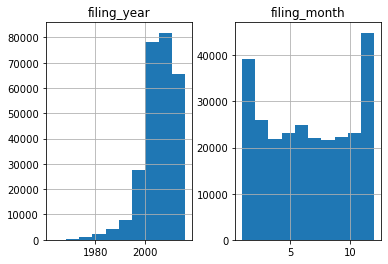

In [15]:
cancer[['filing_year','filing_month']].hist() # Visualize filing frequencies per year and month

<br>We shall work with a subset of data to maintain a low computational burden, and only process titles (patent text downloads are available in USPTO's main repositories) for the same purpose. This data can be downloaded [here](https://www.uspto.gov/learning-and-resources/electronic-data-products/cancer-moonshot-patent-data). 

In case you were interested to fully replicate Kelly et al (2019)'s paper, you may need customized web crawlers that scrape data from [USPTO's Open Data Portal](https://developer.uspto.gov/). A good, interactive tool that uses basic Python scripts can be found [here](https://github.com/mattwang44/USPTO-PatFT-Web-Crawler).

In [17]:
# Select subset of data
cancer_pre2000 = cancer.loc[(cancer['filing_year']<= 1990)] #Patents before 2000
print(cancer_pre2000.shape)

(8935, 16)


In [18]:
# Sort chronologically
cancer_pre2000 = cancer_pre2000.sort_values('filing_date')

# Inspect the first few entries
cancer_pre2000.head()

,patent_id,app_nb,filing_date,publi_date,title,Drugs_and_Chemistry,Diagnostic_and_Surgical_Devices,Radiation_Measurement,Data_Science,Food_and_Nutrition,Model_Systems_and_Animals,Cells_and_Enzymes,Other_and_Preclassification,DNA_RNA_or_Protein_Sequence,filing_year,filing_month
45575,US 3988447 A,04/316466,1963-10-15,19761026,Pharmaceutical preparations,1,0,0,0,0,0,0,0,0,1963,10
268495,US 4012284 A,04/404550,1964-10-06,19770315,Process of preparation of antibiotic F.I. 1762...,0,0,0,0,0,0,0,1,0,1964,10
52333,US 3640268 A,04/503679,1965-10-23,19720208,METHOD AND DEVICE FOR BIOPSY SPECIMEN COLLECTI...,0,1,0,0,0,0,0,0,0,1965,10
52408,US 3560754 A,04/508307,1965-11-17,19710202,PHOTOELECTRIC PARTICLE SEPARATOR USING TIME DELAY,0,1,0,0,0,0,0,0,0,1965,11
15685,US 3681491 A,04/511448,1965-12-03,19720801,BLEOMYCIN AND PROCESSES FOR THE PREPARATION TH...,1,0,0,0,0,0,0,0,0,1965,12


## Text Preprocessing

In [19]:
#Do some quick text cleaning
no_text = ['TITLE NOT AVAILABLE', 'TITLE AVAILABLE IN USOCR DATABASE'] #Goal is to drop rows with such occurrences in the title
print(cancer_pre2000.shape)
cancer_pre2000 = cancer_pre2000[~cancer_pre2000['title'].isin(no_text)] #No such title before 2000
print(cancer_pre2000.shape)

#Lowercase and strip whitespace out of the title column
cancer_pre2000['title'] = cancer_pre2000['title'].str.lower()
cancer_pre2000['title'] = cancer_pre2000['title'].str.strip()

(8935, 16)
(8935, 16)


In [20]:
#Create a list of stopwords: combine the GENSIM and NLTK stopwords
#Gensim
gensim_sws = gensim.parsing.preprocessing.STOPWORDS
print(type(gensim_sws))
print(len(gensim_sws))

gensim_sws_list = list(gensim_sws)
print(type(gensim_sws_list))
print(len(gensim_sws_list))

#NLTK
from nltk.corpus import stopwords
nltk_stop_words = stopwords.words('english') #Load the list of English stopwords from NLTK
print(len(nltk_stop_words))

stop_words = list(set(gensim_sws_list + nltk_stop_words)) #Concatenate the two stop word lists
print(len(stop_words))

<class 'frozenset'>
337
<class 'list'>
337
179
390


In [21]:
#Define pre-processing functions
import string
table = str.maketrans('', '', string.punctuation)

def remove_punctuation(s):
    return s.translate(table)

def remove_words_with_numbers(text):
    result = [x for x in text.split() if not any(c.isdigit() for c in x)]
    res_text = ' '.join(result)
    return res_text

def clean_str(text):
    result=''
    text = remove_punctuation(text)
    res_text = remove_words_with_numbers(text)
    for token in gensim.utils.simple_preprocess(res_text, min_len = 2, max_len = 30) :
        if token not in stop_words: 
            result = result + ' ' + token
            result = result.strip() #Strip whitespace out       
    return result

def clean_list(text):
    result = []
    text = remove_punctuation(text)
    res_text = remove_words_with_numbers(text)
    for token in gensim.utils.simple_preprocess(res_text, min_len = 2, max_len = 30) :
        if token not in stop_words : #and len(token) > 3 can be added to get rid of tokens that are smalller than 3 characters
            result.append(token)   
    return result

<br> __Note__: Below we use lambda functions in a similar vein to how we used them in the first class. If you need any explanation on how these work, check this [article](https://realpython.com/python-lambda/)

In [22]:
#Apply preprocessing function
cancer_pre2000['title_clean'] = cancer_pre2000['title'].apply(lambda x: clean_str(x))
cancer_pre2000['title_clean_list'] = cancer_pre2000['title'].apply(lambda x: clean_list(x))

cancer_pre2000.head()

,patent_id,app_nb,filing_date,publi_date,title,Drugs_and_Chemistry,Diagnostic_and_Surgical_Devices,Radiation_Measurement,Data_Science,Food_and_Nutrition,Model_Systems_and_Animals,Cells_and_Enzymes,Other_and_Preclassification,DNA_RNA_or_Protein_Sequence,filing_year,filing_month,title_clean,title_clean_list
45575,US 3988447 A,04/316466,1963-10-15,19761026,pharmaceutical preparations,1,0,0,0,0,0,0,0,0,1963,10,pharmaceutical preparations,"[pharmaceutical, preparations]"
268495,US 4012284 A,04/404550,1964-10-06,19770315,process of preparation of antibiotic f.i. 1762...,0,0,0,0,0,0,0,1,0,1964,10,process preparation antibiotic fi derivatives,"[process, preparation, antibiotic, fi, derivat..."
52333,US 3640268 A,04/503679,1965-10-23,19720208,method and device for biopsy specimen collecti...,0,1,0,0,0,0,0,0,0,1965,10,method device biopsy specimen collecting handling,"[method, device, biopsy, specimen, collecting,..."
52408,US 3560754 A,04/508307,1965-11-17,19710202,photoelectric particle separator using time delay,0,1,0,0,0,0,0,0,0,1965,11,photoelectric particle separator time delay,"[photoelectric, particle, separator, time, delay]"
15685,US 3681491 A,04/511448,1965-12-03,19720801,bleomycin and processes for the preparation th...,1,0,0,0,0,0,0,0,0,1965,12,bleomycin processes preparation thereof,"[bleomycin, processes, preparation, thereof]"


<br>GENSIM's corpora.dictionary function allows us to inspect the number of unique terms in our data. We could reduce the size of our lexicon here or using _CountVectorizer_ the way we did yesterday. However, for the purposes of this replication exercise we work with very small documents (patent titles) and too many words may be lost by filtering out rare terms. Hence the option is disabled here, but if you are attempting to fully replicate Kelly et al. (2019)'s paper I would encourage you to remove tokens that are too frequent or too rare.

In [23]:
#Create a lexicon containing all unique words
lexicon = gensim.corpora.Dictionary(list(cancer_pre2000['title_clean_list']))
print('Size of clean lexicon is: ', len(lexicon))

# Filter out words that appear very infrequently 
# lexicon.filter_extremes(no_below=2, no_above=0.95)
# print('Size of clean dictionary after filtering out extremes is: ', len(lexicon))


Size of clean lexicon is:  7475


## Term-Document Matrix

This section reproduces Appendix Table A1 using the subset of data and text. 

In [24]:
# Create the Term-Document Matrix with sklearn's CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer() # The simplest CountVectorizer() constructor. 
X = vec.fit_transform(list(cancer_pre2000['title_clean']))
tdm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names()) # Note that individual steps performed in the first class are here combined in a single line. toarray() and todense() are interchangable here
print(tdm.shape)

print(tdm['cancer'].value_counts()) #Number of patent titles that contain a given number of mentions of the word "cancer"

tdm.head()

(8935, 7475)
0    8670
1     252
2      12
3       1
Name: cancer, dtype: int64


,aberrant,ability,ablation,abnormal,abnormalities,abnormality,abnormallyresponding,abortion,abortions,abortus,...,zero,zidovudine,zinc,zincprotaminealpha,zona,zoster,zoxazolamine,zspecific,zygophyllaceae,zymogen
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__Exercise__: Try increasing the parameters you pass here, as done in the first class. 
- For example, try stemming words so that acid and acids are not treated as separate terms.

In [25]:
#Try to compute the number of unique patents each word appears in (distribution of document terms across patents)
tdmc = tdm.copy()
tdmc = np.where(tdmc >= 1, 1, 0) #If a word appears more than once in a patent normalize this count to 1 (we want to count nb of unique patents a word appears in)
tdmc = pd.DataFrame(tdmc, columns=vec.get_feature_names())
print(tdmc['cancer'].value_counts()) #Check how many documents mention the word "cancer"
print(tdmc.shape)
tdmc.head()

0    8670
1     265
Name: cancer, dtype: int64
(8935, 7475)


,aberrant,ability,ablation,abnormal,abnormalities,abnormality,abnormallyresponding,abortion,abortions,abortus,...,zero,zidovudine,zinc,zincprotaminealpha,zona,zoster,zoxazolamine,zspecific,zygophyllaceae,zymogen
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Transpose and do sum of all rows in order to reproduce Appendix Table A1: Summary Statistics of the number of times words appear in patents
tdmc = tdmc.transpose()

tdmc['Total'] = tdmc.sum(axis=1) # Do a column-wise sum
tdmc = tdmc[['Total']] # Keep the only vars we're interested in
tdmc = tdmc.reset_index()
tdmc = tdmc.rename(columns = {'index':'term'})
print(tdmc['Total'].describe()) # Look at some descriptives (basically replicate Appendix Table A1 on the cancer data)
tdmc.head()

count    7475.000000
mean        5.898863
std        35.284090
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max      1346.000000
Name: Total, dtype: float64


,term,Total
0,aberrant,1
1,ability,4
2,ablation,1
3,abnormal,19
4,abnormalities,4


In [27]:
# Have a look at the words that are expressed in the most patents (unique count)
tdmc = tdmc.sort_values('Total', ascending = False)
tdmc.head(20)

,term,Total
4357,method,1346
2029,derivatives,1111
5639,process,988
7291,use,772
5605,preparation,655
1628,compositions,608
6907,thereof,567
1633,compounds,523
5238,pharmaceutical,472
1688,containing,453


## Compute Similarity and Quality of Patents

### Classic TF-IDF vectors

In [28]:
# Compute TF-IDF vectors for each patent
tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range = (1,1))
tf_idfs = tfidf_vectorizer.fit_transform(cancer_pre2000['title_clean'])
print(type(tf_idfs))
print(tf_idfs.shape) # Rows are patents, columns are words. This is a sparse matrix with lots of 0s.

# Calculate sparsity ratio of the resulting TF-IDF matrix
print('Sparsity ratio: ', 100*(1-(tf_idfs.getnnz()/(tf_idfs.shape[0]*tf_idfs.shape[1])))) # This is the sparsity ratio of the TFIDF matrix. Very sparse!

<class 'scipy.sparse.csr.csr_matrix'>
(8935, 7475)
Sparsity ratio:  99.93398026999157


### Pairwise Cosine Similarity

In [29]:
# Calculate pair-wise cosine similarity with sklearn's built-in cosine similarity function
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

pw_cossim = cosine_similarity(tf_idfs, dense_output = False) # Option dense_output can be turned to False if we want a sparse output
print(type(pw_cossim))
print(pw_cossim.shape)

# Get some more info on this sparse matrix
print('Nb of non zero elements in pwcossim: ', pw_cossim.getnnz())
print('Sparsity ratio: ', 100*(1-(pw_cossim.getnnz()/pw_cossim.shape[0]**2))) # This is the sparsity ratio of the pairwise cosine similarity matrix

<class 'scipy.sparse.csr.csr_matrix'>
(8935, 8935)
Nb of non zero elements in pwcossim:  8409728
Sparsity ratio:  89.46601160091427


In [30]:
#If similarity is below 0.05 set it to 0
nnz_inds = pw_cossim.nonzero()
keep = np.where(pw_cossim.data >= 0.05)[0]
pw_cossim = csr_matrix((pw_cossim.data[keep], (nnz_inds[0][keep], nnz_inds[1][keep])), shape=pw_cossim.shape)

#Calculate the new sparsity ratio after setting similarity coefficients that are below 0.05 to 0
print('Sparsity ratio: ', 100*(1-(pw_cossim.getnnz()/pw_cossim.shape[0]**2)))

Sparsity ratio:  92.34005465700957


In [31]:
#Get some descriptive statistics on these pairwise similarity coefficients
print(stats.describe(pw_cossim.data))

DescribeResult(nobs=6115258, minmax=(0.05000000843664327, 1.0000000000000007), mean=0.12612903359620609, variance=0.009282656734469626, skewness=3.7751081741679795, kurtosis=23.20069328290301)


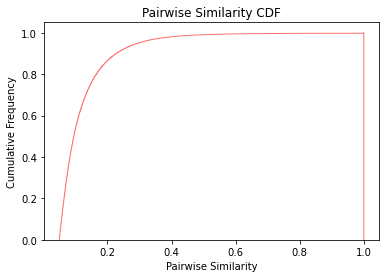

In [32]:
#Plot the CDF
plt.hist(pw_cossim.data, density=True, cumulative=True, label='CDF DATA', 
         histtype='step', alpha=0.55, color='red', bins = 1000)
plt.xlabel('Pairwise Similarity')
plt.ylabel('Cumulative Frequency')
plt.title('Pairwise Similarity CDF')
plt.savefig(maindir + 'results/pairwise_simil_CDF.png')
plt.show()

<br>__Exercise__: Plot a similar CDF but using various time-windows (e.g. 5 years, 10 years, 20 years) as a filter for defining similarity.
 - Goal: Plot the distribution of similarity by focusing on patents that are 5/10/20 years apart.
 - tip: Use a boolean mask matrix as below to filter out pairs that are not within a certain time window.


In [35]:
print(pw_cossim.data)

[1.         0.32872064 0.27048463 ... 0.10097363 0.19161445 1.        ]


### Backward and Forward Similarity Measures

In [36]:
#Now build a backward boolean mask by using the filing date year of patents
year_arr = cancer_pre2000['filing_year'].to_numpy() #Convert the year column to a numpy array
print(type(year_arr))
print(year_arr.shape)

#Create the backwards mask
mask = (year_arr[:,None] > year_arr) & (year_arr[:,None] - 5 <= year_arr) #Is True if own year is strictly higher than other years within a 5-year backward window
print(mask.shape, pw_cossim.shape)

mask = sparse.csr_matrix(mask) #Convert the mask numpy matrix to a sparse matrix
print(type(mask), type(pw_cossim)) #Check

#Apply the backward mask to the similarity matrix and then calculate column-wise sum
bw_simil = pw_cossim.multiply(mask).sum(axis=1)
print(type(bw_simil), bw_simil.shape)

<class 'numpy.ndarray'>
(8935,)
(8935, 8935) (8935, 8935)
<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrix'> (8935, 1)


In [37]:
#Do the same for forward similarity
#Create the forward mask
mask = (year_arr[:,None] < year_arr) & (year_arr[:,None] + 5 >= year_arr)
mask = sparse.csr_matrix(mask) #Convert to sparse rpz

#Apply the backward mask to the similarity matrix and then calculate column-wise sum
fw_simil = pw_cossim.multiply(mask).sum(axis=1)
print(type(fw_simil), fw_simil.shape)

<class 'numpy.matrix'> (8935, 1)


In [38]:
# "Append" these measures to the pandas DF cancer_pre2000
#First convert numpy matrices to DF
bw_simildf = pd.DataFrame(bw_simil)
print(bw_simildf.shape, bw_simildf.columns)
bw_simildf = bw_simildf.reset_index()
print(bw_simildf.columns)
bw_simildf.rename(columns = {0: 'bw_simil', 'index': 'index_col'}, inplace = True)

#Same thing for forward similarity
fw_simildf = pd.DataFrame(fw_simil)
print(fw_simildf.shape, fw_simildf.columns)
fw_simildf = fw_simildf.reset_index()
print(fw_simildf.columns)
fw_simildf.rename(columns = {0: 'fw_simil', 'index': 'index_col'}, inplace = True)

#Merge the two DFs on the index_col column
simils = pd.merge(bw_simildf, fw_simildf, on = 'index_col', indicator = True)
print(simils['_merge'].value_counts())

#Drop the _merge col
simils.drop('_merge', axis = 1, inplace = True)

simils.head()

(8935, 1) RangeIndex(start=0, stop=1, step=1)
Index(['index', 0], dtype='object')
(8935, 1) RangeIndex(start=0, stop=1, step=1)
Index(['index', 0], dtype='object')
both          8935
right_only       0
left_only        0
Name: _merge, dtype: int64


,index_col,bw_simil,fw_simil
0,0,0.000000,0.599205
1,1,0.000000,2.997364
2,2,0.000000,0.838673
3,3,0.000000,0.000000
4,4,0.096308,0.930838


In [39]:
#Calculate patent quality
simils['patent_quality'] = simils['fw_simil']/simils['bw_simil']
cols = ['patent_quality', 'fw_simil', 'bw_simil']

#Do some checks and get some descriptive statistics on the similarity measures and on the quality measure
for col in cols:
    print('Nb of Nans in col', col, ' is: ', simils[col].isnull().sum())
    print('Sum stats for', col, ' is: ', simils[col].describe())

Nb of Nans in col patent_quality  is:  248
Sum stats for patent_quality  is:  count    8687.000000
mean             inf
std              NaN
min         0.000000
25%         0.460352
50%         1.370667
75%         2.236047
max              inf
Name: patent_quality, dtype: float64
Nb of Nans in col fw_simil  is:  0
Sum stats for fw_simil  is:  count    8935.000000
mean       23.194960
std        26.091029
min         0.000000
25%         4.120559
50%        14.834372
75%        32.915135
max       197.046234
Name: fw_simil, dtype: float64
Nb of Nans in col bw_simil  is:  0
Sum stats for bw_simil  is:  count    8935.000000
mean       23.194960
std        24.060447
min         0.000000
25%         5.863226
50%        15.859953
75%        32.868166
max       225.613296
Name: bw_simil, dtype: float64


In [40]:
#More checks and info
print(bw_simildf['bw_simil'].isnull().sum())
print(bw_simildf['bw_simil'].describe())
print('Number of patents with backward similarity equal to zero: ', sum(bw_simildf['bw_simil']==0))

print('Number of patents with forward similarity equal to zero: ', sum(fw_simildf['fw_simil']==0)) 

print('Number of patents with forward similarity and backward similarity equal to zero: ', sum((fw_simildf['fw_simil']==0) & (bw_simildf['bw_simil']==0))) 


0
count    8935.000000
mean       23.194960
std        24.060447
min         0.000000
25%         5.863226
50%        15.859953
75%        32.868166
max       225.613296
Name: bw_simil, dtype: float64
Number of patents with backward similarity equal to zero:  348
Number of patents with forward similarity equal to zero:  1286
Number of patents with forward similarity and backward similarity equal to zero:  248


In [41]:
#Merge to the cancer_pre2000 dataset
cancer_pre2000['index_col'] = np.arange(len(cancer_pre2000)) #Create the merge key in the cancer DF

cancer_pre2000 = pd.merge(cancer_pre2000, simils, on = 'index_col', how = 'left', indicator = True)
print(cancer_pre2000['_merge'].value_counts())
cancer_pre2000.drop('_merge', axis = 1, inplace = True)
cancer_pre2000.tail()

both          8935
right_only       0
left_only        0
Name: _merge, dtype: int64


,patent_id,app_nb,filing_date,publi_date,title,Drugs_and_Chemistry,Diagnostic_and_Surgical_Devices,Radiation_Measurement,Data_Science,Food_and_Nutrition,...,Other_and_Preclassification,DNA_RNA_or_Protein_Sequence,filing_year,filing_month,title_clean,title_clean_list,index_col,bw_simil,fw_simil,patent_quality
8930,US 5256540 A,07/636066,1990-12-28,19931026,immunoassay for small cell lung carcinoma,0,1,0,0,0,...,0,0,1990,12,immunoassay small cell lung carcinoma,"[immunoassay, small, cell, lung, carcinoma]",8930,26.766413,0.0,0.0
8931,US 5137919 A,07/636353,1990-12-31,19920811,"effect of n,n,n,-trimethylsphingosine on prote...",1,0,0,0,0,...,0,0,1990,12,effect nnntrimethylsphingosine protein kinase ...,"[effect, nnntrimethylsphingosine, protein, kin...",8931,33.200368,0.0,0.0
8932,US 5123904 A,07/633194,1990-12-31,19920623,surgical resecting instrument,0,1,0,0,0,...,0,0,1990,12,surgical resecting instrument,"[surgical, resecting, instrument]",8932,2.943622,0.0,0.0
8933,US 5122526 A,07/636252,1990-12-31,19920616,camptothecin and analogs thereof and pharmaceu...,1,0,0,0,0,...,0,0,1990,12,camptothecin analogs thereof pharmaceutical co...,"[camptothecin, analogs, thereof, pharmaceutica...",8933,108.741964,0.0,0.0
8934,US 5227380 A,07/636150,1990-12-31,19930713,pharmaceutical compositions and methods employ...,1,0,0,0,0,...,0,0,1990,12,pharmaceutical compositions methods employing ...,"[pharmaceutical, compositions, methods, employ...",8934,70.612531,0.0,0.0


In [42]:
#Checks on the 0 values for the similarity measures
#Checking those cases where backward similarity is 0
zero_bwsimil = cancer_pre2000.loc[cancer_pre2000['bw_simil']==0]
print(zero_bwsimil.shape)
print(zero_bwsimil['filing_year'].value_counts())

#Same thing but for those cases where forward similarity is 0
zero_fwsimil = cancer_pre2000.loc[cancer_pre2000['fw_simil']==0]
print(zero_fwsimil.shape)
print(zero_fwsimil['filing_year'].value_counts())

(348, 22)
1982    27
1986    24
1979    21
1988    20
1985    20
1990    19
1987    17
1984    17
1981    17
1973    17
1974    17
1975    15
1983    15
1977    14
1980    14
1989    12
1969    12
1978    11
1971    11
1976    10
1970     5
1972     4
1967     3
1968     2
1965     2
1964     1
1963     1
Name: filing_year, dtype: int64
(1286, 22)
1990    1013
1988      24
1986      24
1982      24
1989      22
1979      19
1984      17
1983      16
1987      14
1981      14
1974      13
1985      12
1973      12
1977      12
1978      10
1976       8
1980       8
1975       7
1969       7
1970       3
1972       2
1971       2
1968       1
1967       1
1965       1
Name: filing_year, dtype: int64


In [43]:
#Replace the 0s in bw_simil by NANS and then recalculate quality
print('Nb of Nans in col', 'bw_simil', ' is: ', cancer_pre2000['bw_simil'].isnull().sum())
cancer_pre2000['bw_simil'] = cancer_pre2000['bw_simil'].replace(0, np.nan)
print('Nb of Nans in col', 'bw_simil', ' is: ', cancer_pre2000['bw_simil'].isnull().sum())

cancer_pre2000['patent_quality'] = cancer_pre2000['fw_simil']/cancer_pre2000['bw_simil']
print('Nb of Nans in col', 'patent_quality', ' is: ', cancer_pre2000['patent_quality'].isnull().sum())
print('Sum stats of col', 'patent_quality', ' is: ', cancer_pre2000['patent_quality'].describe())


Nb of Nans in col bw_simil  is:  0
Nb of Nans in col bw_simil  is:  348
Nb of Nans in col patent_quality  is:  348
Sum stats of col patent_quality  is:  count    8587.000000
mean        1.799582
std         2.983266
min         0.000000
25%         0.447651
50%         1.346822
75%         2.207890
max        83.639114
Name: patent_quality, dtype: float64


### Plots of Patent Quality

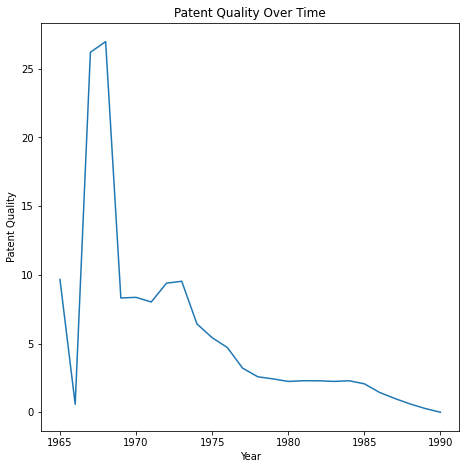

In [44]:
#Plot the evolution of patent quality over time
#Do a groupby on filing year to get the mean patent quality in each year
yearly_qual = cancer_pre2000.dropna(subset = ['patent_quality']).groupby(['filing_year'])['patent_quality'].mean().reset_index()

#Do the plot
plt.figure(figsize=(7.5, 7.5))
plt.plot(yearly_qual['filing_year'], yearly_qual['patent_quality'])
plt.xlabel('Year')
plt.ylabel('Patent Quality')
plt.title('Patent Quality Over Time')
plt.savefig(maindir + 'results/evolution_patent_quality.png')
plt.show()

90th percentile of the patent quality distribution is:  3.4441447769301274


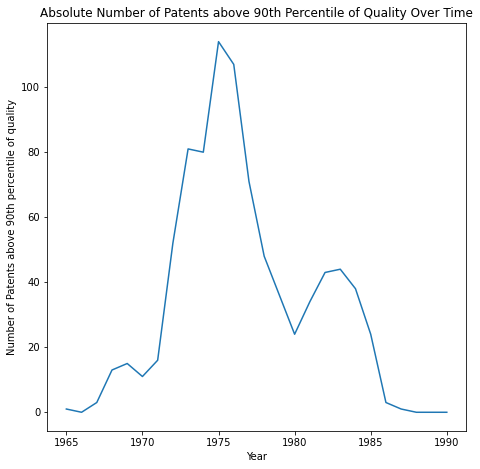

In [45]:
#Plot the evolution over time of number of patents in the top 10% of patent quality
#print('Sum stats of col', 'patent_quality', ' is: ', cancer_pre2000['patent_quality'].describe())
topten_thresh = cancer_pre2000['patent_quality'].quantile(0.9)
print('90th percentile of the patent quality distribution is: ', topten_thresh)
cancer_pre2000['top_tenpct'] = np.where((cancer_pre2000['patent_quality']>= topten_thresh), 1, 0) #Create a dummy for whether the patent is above the 90th percentile of quality

#Count, for each year, the absolute number of patents above the 90th percentile of quality
yearly_topten = cancer_pre2000.dropna(subset = ['patent_quality']).groupby(['filing_year'])['top_tenpct'].sum().reset_index()

#Plot the absolute number of patents within a given year that are above the 90th percentile of quality ("breakthrough innovations")
plt.figure(figsize=(7.5, 7.5))
plt.plot(yearly_topten['filing_year'], yearly_topten['top_tenpct'])
plt.xlabel('Year')
plt.ylabel('Number of Patents above 90th percentile of quality')
plt.title('Absolute Number of Patents above 90th Percentile of Quality Over Time')
plt.savefig(maindir + 'results/evolution_toptenpct_patents.png')
plt.show()

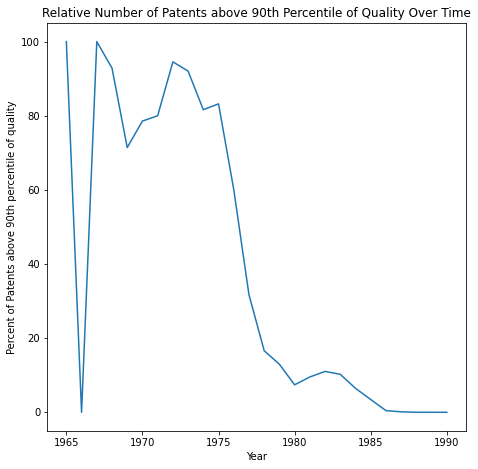

In [46]:
#Plot the evolution over time of the relative number of patents in the top 10% of patent quality (absolute nb/nb of patents in given year)
#Get the number of patents per year
nb_patents_year = cancer_pre2000.dropna(subset = ['patent_quality']).groupby(['filing_year'])['patent_quality'].count().reset_index()
nb_patents_year.rename(columns = {'patent_quality': 'nb_patents'}, inplace = True)
yearly_topten = pd.merge(yearly_topten, nb_patents_year, on = 'filing_year') #Merge the two DFs

yearly_topten['pct_patents_in_topten'] = 100*(yearly_topten['top_tenpct']/yearly_topten['nb_patents'])

#Plot the share of patents within a given year that are above the 90th percentile of quality
yearly_topten['pct_patents_in_topten'] = 100*(yearly_topten['top_tenpct']/yearly_topten['nb_patents'])

plt.figure(figsize=(7.5, 7.5))
plt.plot(yearly_topten['filing_year'], yearly_topten['pct_patents_in_topten'])
plt.xlabel('Year')
plt.ylabel('Percent of Patents above 90th percentile of quality')
plt.title('Relative Number of Patents above 90th Percentile of Quality Over Time')
plt.savefig(maindir + 'results/evolution_share_topten_patents.png')
plt.show() # Note that the large values at the beginning correspond to issues of small sample size (term observations). A more exhaustive replication would not contend with this issue 

In [47]:
#Print the share of patents of a given year over the number of patents of the whole period (relative freq)
nb_total_patents = len(cancer_pre2000.dropna(subset = ['patent_quality']))
print('Total nb of patents with a valid measure of patent quality: ', nb_total_patents)
nb_patents_year['share_total'] = 100*(nb_patents_year['nb_patents']/nb_total_patents)
nb_patents_year

Total nb of patents with a valid measure of patent quality:  8587


,filing_year,nb_patents,share_total
0,1965,1,0.011646
1,1966,1,0.011646
2,1967,3,0.034937
3,1968,14,0.163037
4,1969,21,0.244556
5,1970,14,0.163037
6,1971,20,0.232910
7,1972,55,0.640503
8,1973,88,1.024805
9,1974,98,1.141260


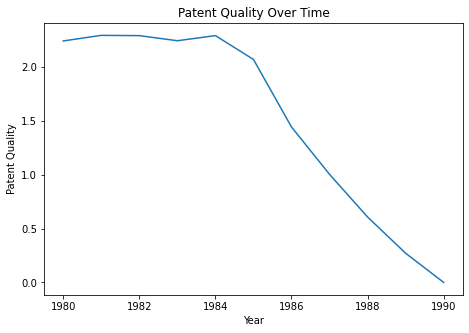

In [50]:
#Seems safe to remove years prior to 1980 (below 0.5%) (accounts for less than 1% of all patents with valid measure of quality)
#Plot the evolution of patent quality over time
#yearly_qual = cancer_pre2000.dropna(subset = ['patent_quality']).groupby(['filing_year'])['patent_quality'].mean().reset_index()
yearly_qual_sub = yearly_qual[yearly_qual['filing_year']>=1980]
#Do the plot
plt.figure(figsize=(7.5, 5))
plt.plot(yearly_qual_sub['filing_year'], yearly_qual_sub['patent_quality'])
plt.xlabel('Year')
#plt.xticks(ticks = [1980, 1985, 1990, 1995, 2000], labels = ['1980', '1985', '1990', '1995', '2000'])
plt.ylabel('Patent Quality')
plt.title('Patent Quality Over Time')
plt.savefig(maindir + 'results/evolution_patent_quality_subsample.png')
plt.show()

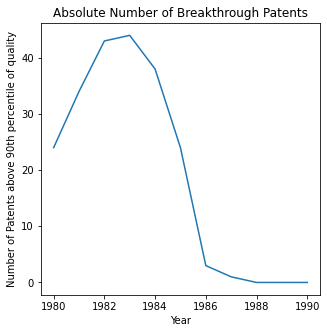

In [51]:
#Same subsampling for absolute number of patents in the 90th percentile of quality

yearly_topten_sub = yearly_topten[yearly_topten['filing_year']>=1980]

#Plot the absolute number of patents within a given year that are above the 90th percentile of quality ("breakthrough innovations")
plt.figure(figsize=(5, 5))
plt.plot(yearly_topten_sub['filing_year'], yearly_topten_sub['top_tenpct'])
plt.xlabel('Year')
#plt.xticks(ticks = [1980, 1985, 1990, 1995, 2000], labels = ['1980', '1985', '1990', '1995', '2000'])
plt.ylabel('Number of Patents above 90th percentile of quality')
plt.title('Absolute Number of Breakthrough Patents')
plt.savefig(maindir + 'results/evolution_toptenpct_patents_subsample.png')
plt.show()

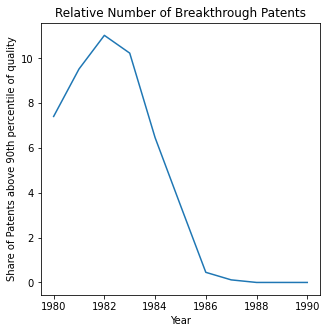

In [52]:
#Plot the relative number of patents within a given year that are above the 90th percentile of quality ("breakthrough innovations")
plt.figure(figsize=(5, 5))
plt.plot(yearly_topten_sub['filing_year'], yearly_topten_sub['pct_patents_in_topten'])
plt.xlabel('Year')
#plt.xticks(ticks = [1980, 1985, 1990, 1995, 2000], labels = ['1980', '1985', '1990', '1995', '2000'])
plt.ylabel('Share of Patents above 90th percentile of quality')
plt.title('Relative Number of Breakthrough Patents')
plt.savefig(maindir + 'results/evolution_share_topten_patents_subsample.png')
plt.show()